In [11]:
from pathlib import Path

import numpy as np
import xarray as xr

In [12]:
# Grab spectra_LES.nc
ds = xr.open_dataset(Path("spectra_LES.nc"))

In [23]:
radius_ds = ds['radius']
height_ds = ds['height']
frequency_ds = ds['frequency']
spectralDensity_UV_ds = ds['spectralDensity_UV']


In [25]:
print(radius_ds.shape)
print(height_ds.shape)
print(frequency_ds.shape)
print(spectralDensity_UV_ds.shape)

(1,)
(60,)
(3001,)
(1, 60, 3001)


In [13]:
radius = np.array(ds['radius'])
height = np.array(ds['height'])
frequency = np.array(ds['frequency'])
spectralDensity_UV = np.array(ds['spectralDensity_UV'])
ds.close()

In [14]:
radius

array([0.97975006])

In [15]:
height

array([  1.97432877,   6.41284959,  11.33760765,  16.25687486,
        21.17240678,  26.08389105,  30.9922806 ,  35.89835659,
        40.80301207,  45.70342757,  50.60073249,  55.50221101,
        60.40724671,  65.31086635,  70.2131177 ,  75.11144972,
        80.006168  ,  84.90091085,  89.79546641,  94.69107127,
        99.58753307, 104.48442922, 109.38086359, 114.27735606,
       119.17178536, 124.06465763, 128.96126922, 133.8618684 ,
       138.76383758, 143.66357644, 148.56202536, 153.45990641,
       158.35626856, 163.25402819, 168.1515083 , 173.04750617,
       177.94467027, 182.84396835, 187.74228085, 192.63985118,
       197.53982288, 202.44195127, 207.34066942, 212.23429308,
       217.12862018, 222.02512543, 226.92358137, 231.81986572,
       236.71352821, 241.60893895, 246.50658315, 251.40647192,
       256.30617414, 261.20325519, 266.1001674 , 270.99936031,
       275.90081345, 280.80429162, 285.70664297, 290.60899433])

In [18]:
frequency.shape

(3001,)

In [19]:
spectralDensity_UV.shape

(1, 60, 3001)

In [22]:
_spectralDensity_UV = np.squeeze(spectralDensity_UV)
_spectralDensity_UV.shape

(60, 3001)

In [26]:
import matplotlib.pyplot as plt

In [28]:
rad = radius[0]

In [32]:
h = height[30]
spectralDensity_UV_h = np.squeeze(spectralDensity_UV[:, 30, :])

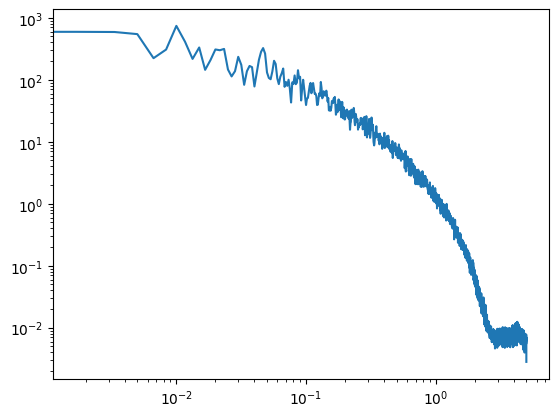

In [35]:

plt.loglog(frequency[:], spectralDensity_UV_h[:])

plt.show()


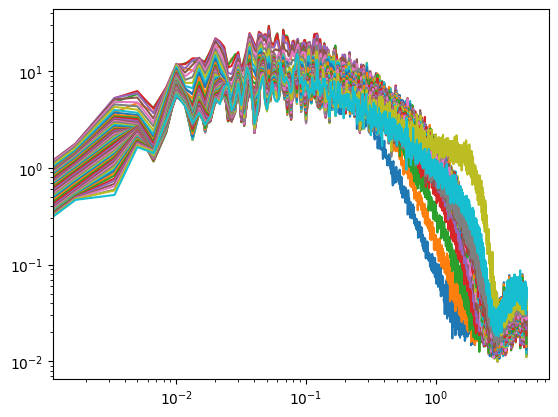

In [38]:
# I have height, frequency, and spectralDensity_UV
# which are
# height: 60 values
# frequency: 3001 values
# spectralDensity_UV: 60 x 3001

plt.figure()
for i in range(60):
    plt.loglog(frequency[:], frequency[:] * spectralDensity_UV[0, i, :])
plt.show()


